In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import  roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import lightgbm as lgb

import shap
from fastparquet import ParquetFile
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor

from utils import feature_drop, remove_highly_correlated_features

/cephfs/projects/ppashin/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/tmp/ipykernel_100827/2436158417.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
file_path = "Data/train_ai_comp_final_dp.parquet"
pf = ParquetFile(file_path)
df = pf.to_pandas()
df = feature_drop(df)
df.head()

,id,target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature1067,feature1068,feature1069,feature1070,feature1071,feature1072,feature1073,feature1074,feature1075,feature1076
0,0,0,1761,1759,85,105469,191,46,0,6,...,28913,48985,84264,12045,12107,12510,21126,28913,48985,84264
1,1,0,1761,1759,120,105610,144,71,0,135,...,0,0,0,0,0,0,0,0,0,0
2,2,0,890,1759,141,105227,191,11,0,0,...,55949,70006,113317,33735,31242,12691,48682,55949,70006,113317
5,5,0,1599,966,30,102441,191,8,0,0,...,0,6872,8530,0,0,0,0,0,6872,8530
6,6,0,1761,1759,85,104006,191,2,0,0,...,0,0,7642,0,0,0,0,0,0,7642


### Удаление по корреляции

In [3]:
fature_to_drop = remove_highly_correlated_features(df, threshold=0.95)
df.drop(columns=fature_to_drop, inplace=True)

In [4]:
df.head()

,id,target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature9,...,feature1055,feature1056,feature1057,feature1059,feature1063,feature1064,feature1065,feature1066,feature1068,feature1069
0,0,0,1761,1759,85,105469,191,46,0,95,...,0,0,0,0,12045,12107,12510,21126,48985,84264
1,1,0,1761,1759,120,105610,144,71,0,135,...,0,0,0,0,0,0,0,0,0,0
2,2,0,890,1759,141,105227,191,11,0,0,...,0,0,0,0,33735,31242,12691,48682,70006,113317
5,5,0,1599,966,30,102441,191,8,0,0,...,0,5220,0,5810,0,0,0,0,6872,8530
6,6,0,1761,1759,85,104006,191,2,0,46,...,0,0,0,0,0,0,0,0,0,7642


### Деление на train, test, validation

In [5]:
X = df.drop(columns=['target', "id"])
y = df['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Отбор по Mutual Info

In [6]:
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=100000, random_state=42, stratify=y_train)

In [7]:
X_sample

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature9,feature12,feature18,...,feature1055,feature1056,feature1057,feature1059,feature1063,feature1064,feature1065,feature1066,feature1068,feature1069
224294,531,173,141,87836,191,6,125,298,187,28,...,0,0,0,0,0,0,0,0,0,0
222846,1666,731,122,103688,191,73,0,142,70,11,...,0,0,0,0,0,0,0,0,0,0
388567,1761,1759,141,103219,191,67,0,0,77,28,...,0,0,0,0,0,0,0,0,0,0
657619,1761,1759,73,97743,191,4,0,41,63,3,...,0,0,0,0,0,0,0,0,29173,34620
374392,1472,64,24,105146,191,32,0,17,61,1,...,0,0,0,0,0,8615,0,8426,27137,31901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105324,1642,1759,79,104861,16,72,0,16,138,1,...,0,0,0,0,0,0,44720,0,74154,99832
126657,1761,1759,24,103959,11,11,0,0,187,28,...,0,0,0,0,0,0,0,0,0,0
112472,1761,1759,14,92510,128,60,0,25,187,2,...,0,0,0,0,0,0,0,0,0,0
113095,1761,1759,20,102609,191,60,125,298,187,28,...,0,0,0,0,0,0,0,0,0,0


In [8]:
mi_scores = mutual_info_classif(X_sample.dropna(axis=1), y_sample)
threshold = np.median(mi_scores) 
selected_features_indices = [i for i, mi_score in enumerate(mi_scores) if mi_score > threshold]

# отобранные признаки для дальнейшей работы
selected_features_names = X_sample.dropna(axis=1).columns[selected_features_indices]

# имена для выбора столбцов из X_train и X_test
X_train_selected = X_train[selected_features_names]
X_test_selected = X_test[selected_features_names]

X_test_selected.head()

,feature1,feature2,feature4,feature5,feature12,feature19,feature22,feature23,feature24,feature25,...,feature936,feature937,feature945,feature946,feature947,feature989,feature993,feature994,feature1003,feature1004
110947,1640,1759,101987,94,106,206,0,9,248,1722,...,198929,152144,78495,225035,167953,5,16,32,17,36
179283,140,15,54203,191,187,248,140184,9,248,1722,...,198929,152144,78495,225035,167953,1,5,5,3,3
453240,1058,941,27390,191,187,248,140184,9,248,1722,...,198929,152144,78495,225035,167953,1,12,21,10,19
408592,1449,0,104397,19,42,7,115837,9,248,993,...,198929,152144,78495,225035,167953,3,6,6,5,5
37285,1640,1759,102296,147,187,18,74352,9,248,1722,...,76344,152144,31163,100076,12676,3,18,35,19,38


In [9]:
with open('feature.txt', 'w', encoding='utf-8') as file:
    for item in selected_features_names:
        file.write("%s\n" % item)

In [10]:
X_test, X_train, X_val = X_test[selected_features_names], X_train[selected_features_names], X_val[selected_features_names]

In [11]:
X_test.shape, X_train.shape, X_val.shape

((77943, 339), (363730, 339), (77942, 339))

### LightGBM на отобранных фичах

In [12]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'gain',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0,
    'n_estimators': 10000,
    'num_leaves': 31,
    'objective': "binary",
    'random_state': 9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'metric': 'auc',
    'gpu_use_dp': True,
    "early_stopping_rounds":300
}

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lightgbm = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, val_data])
y_train_pred = lightgbm.predict(X_train)
y_val_pred = lightgbm.predict(X_val)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_val, y_val_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc test {roc_auc_test}")

/cephfs/projects/ppashin/.local/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 13005, number of negative: 350725
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49061
[LightGBM] [Info] Number of data points in the train set: 363730, number of used features: 329
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035755 -> initscore=-3.294669
[LightGBM] [Info] Start training from score -3.294669
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[81]	training's auc: 0.802432	va

### Отбор фичей по SHAP и 3м моделям

In [13]:
feature = set()

### SHAP для LightGBM

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13005, number of negative: 350725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49082
[LightGBM] [Info] Number of data points in the train set: 363730, number of used features: 328
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035755 -> initscore=-3.294669
[LightGBM] [Info] Start training from score -3.294669
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LightGBM ROC-AUC: 0.7181025439865193


100%|===================| 77892/77942 [03:19<00:00]        

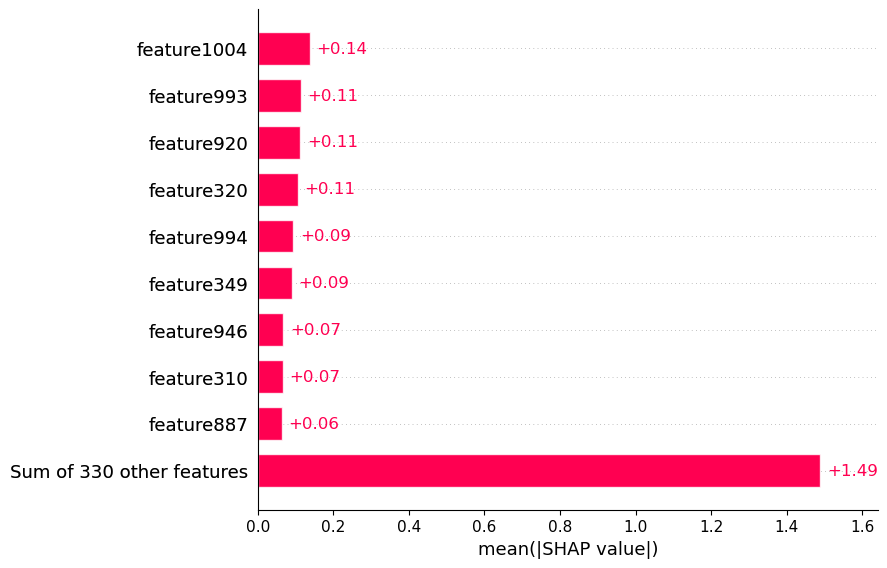

In [14]:
light_gbm = lgb.LGBMClassifier(n_estimators=100, random_state=42, max_depth=10)
light_gbm.fit(X_train, y_train)
light_gbm_proba = light_gbm.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, light_gbm_proba)
print(f"LightGBM ROC-AUC: {roc_auc}")
explainer = shap.Explainer(light_gbm, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))
shap_sum = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
feature_importance.columns = ['feature', 'shap_importance']
feature.update(feature_importance["feature"][feature_importance["shap_importance"] > 0])

### SHAP для XGBoost

XGBoost ROC-AUC: 0.6800722121508924


100%|===================| 77790/77942 [07:39<00:00]        

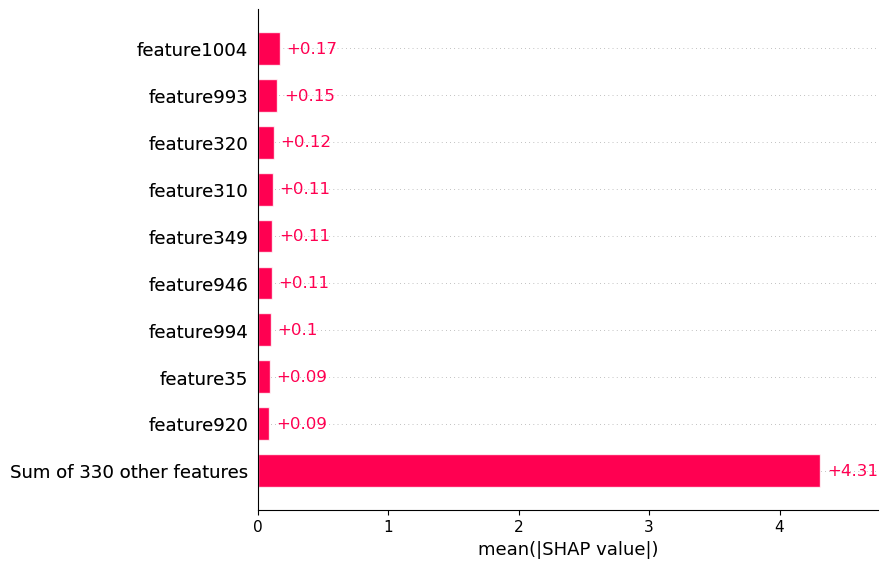

In [15]:
xg_boost = XGBClassifier(n_estimators=100, random_state=42, max_depth=10)
xg_boost.fit(X_train, y_train)
xg_boost_proba = xg_boost.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, xg_boost_proba)
print(f"XGBoost ROC-AUC: {roc_auc}")
explainer = shap.Explainer(xg_boost, X_train)
shap_values = explainer(X_val)
shap.plots.bar(shap_values.abs.mean(0))
shap_sum = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
feature_importance.columns = ['feature', 'shap_importance']
feature.update(feature_importance["feature"][feature_importance["shap_importance"] > 0])

### SHAP для Random Forest 

XGBoost ROC-AUC: 0.7044648032855279


100%|===================| 155784/155884 [25:12<00:00]        

TypeError: 'numpy.float64' object is not iterable

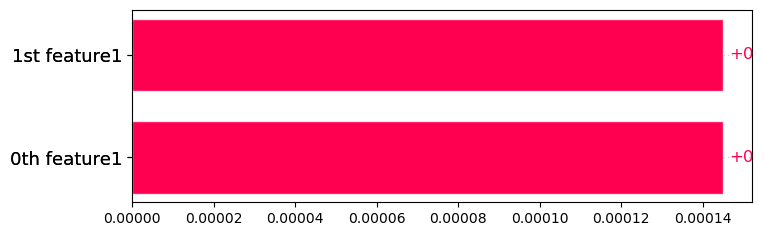

In [16]:
randon_forest = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
randon_forest.fit(X_train, y_train)
randon_forest_proba = randon_forest.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, randon_forest_proba)
print(f"XGBoost ROC-AUC: {roc_auc}")
explainer = shap.Explainer(randon_forest, X_train)
shap_values = explainer(X_val)


LightGBM on selected by SHAP values

In [24]:
X_train, X_val, X_test = X_train[list(feature)], X_val[list(feature)], X_test[list(feature)]

In [25]:
X_train

,feature93,feature116,feature786,feature1,feature149,feature888,feature61,feature925,feature935,feature815,...,feature120,feature688,feature887,feature994,feature879,feature712,feature880,feature831,feature562,feature817
305172,7872,68601,1,408,260009,10653,833,31,62319,996,...,103856,1,346,32,844,1,3016,1306,1,254
180948,7872,68601,1,1618,260009,9675,833,31,62319,996,...,85492,1,6587,13,9815,1,3016,1306,1,1727
319360,7872,191,1,1650,1924,7357,833,31,62319,336,...,23513,1,6587,29,7494,1,3016,1306,1,1727
9967,7872,68601,1,1761,260009,10653,833,2,62319,996,...,103856,1,6587,20,13781,1,3016,1306,1,1727
336341,7872,68601,1,1712,158675,10653,833,31,62319,226,...,103856,0,6587,24,13781,1,3016,1306,1,812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346164,7872,68601,1,1633,2247,10653,833,31,62319,783,...,73527,1,6587,18,13781,1,3016,1306,1,1727
488156,7872,68601,1,1761,176273,9827,833,31,49551,36,...,21997,1,6587,25,9969,1,3016,1306,1,1727
176273,7872,68601,1,1633,260009,10653,833,31,62319,996,...,103856,1,6587,22,8908,1,3016,1306,1,1727
196223,757,5839,1,1761,237854,10653,833,25,56531,914,...,52642,0,4480,35,13781,1,3016,1306,1,1727


In [26]:
params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'gain',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0,
    'n_estimators': 10000,
    'num_leaves': 31,
    'objective': "binary",
    'random_state': 9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'silent': True,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0,
    'metric': 'auc',
    'gpu_use_dp': True,
    "early_stopping_rounds":300
}

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

lightgbm = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, val_data])
y_train_pred = lightgbm.predict(X_train)
y_val_pred = lightgbm.predict(X_val)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_val, y_val_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc test {roc_auc_test}")

/cephfs/projects/ppashin/.local/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 13005, number of negative: 350725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48716
[LightGBM] [Info] Number of data points in the train set: 363730, number of used features: 304
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035755 -> initscore=-3.294669
[LightGBM] [Info] Start training from score -3.294669
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[92]	training's auc: 0.809184	valid_1's auc: 0.721322
roc-auc train 0.8091841778066737
roc-auc t

In [27]:
y_train_pred = lightgbm.predict(X_train)
y_test_pred = lightgbm.predict(X_test)

roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"roc-auc train {roc_auc_train}")
print(f"roc-auc test {roc_auc_test}")

roc-auc train 0.8091841778066737
roc-auc test 0.7154502457715944


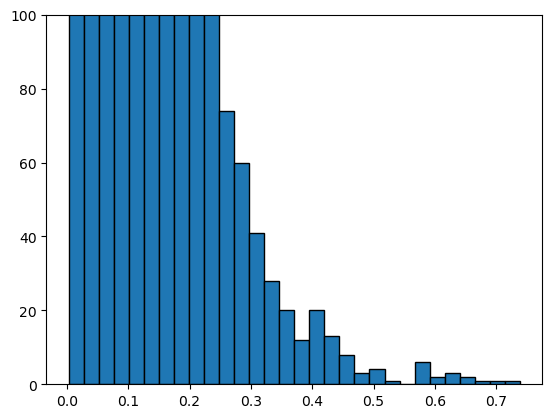

In [40]:
import matplotlib.pyplot as plt
plt.hist(light_gbm_proba, bins=30, edgecolor='black')
plt.ylim(0, 100)
None